# Effects of Clioquinol on Yeast

**Author:** [Tony Kabilan Okeke](mailto:tko35@drexel.edu)  
**Date:**   04.17.2022

Analyze the microarray dataset made available by the following study: [*"The metal chelating and chaperoning effects of clioquinol: insights from yeast studies"*](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:qsb:ma:clioquinol.yeast.Li2010.pdf).

The microarray data is available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE17257).

- Show a hierarchical clustering of samples. (Just a hierarchical clustering (ie a dendrogram) of samples, not a heatmap of expression values).
- Show a clustergram (heatmap, combined with clustering of samples and clustering of genes) of expression values.
- Report the top 10 most different genes between the Clioquinol and control groups.
- Report the functional annotations (GO Biological Processes and KEGG Pathways) that are significantly different between the two groups.
- Discuss whether your results align with the findings reported in the paper.
- 5% of your grade is for optimizing download & parse functions.

In [1]:
%load_ext autoreload

In [2]:
# Imports
%autoreload 2
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import re, math, rich, tools
from statsmodels.stats import multitest
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy import stats

In [3]:
# Download and parse GSE and GPL data
gse = tools.geodlparse('GSE17257')
gpl = tools.geodlparse(*gse.metadata['platform_id'])

# Prepare dataframe with expression values
gse_data = pd.concat(
    [ gsm.table.set_index('ID_REF')['VALUE'] for _,gsm in gse.gsms.items() ],
    axis=1
).set_axis([ x for x,_ in gse.gsms.items() ], axis=1, inplace=False)

# Merge gse data with genes from the GPL
gse_data = gse_data \
    .merge(gpl.table[['ID', 'Gene Symbol']], how='left', 
           left_index=True, right_on='ID') \
    .rename({'ID_REF': 'ID', 'Gene Symbol': 'Gene'}, axis=1) \
    .set_index(['ID', 'Gene']) \
    .sort_index(axis=1)

# Label columns as 'Control' or 'Clioquinol'
columns = gse.phenotype_data['title'] \
    .apply(lambda x: re.search(r'DMSO|CQ', x)[0]) \
    .replace({'DMSO': 'Control', 'CQ': 'Clioquinol'}) \
    .sort_index().reset_index()
gse_data.columns = [columns['index'].values, columns['title'].values]

gse_data.head()

Loading cached data...
Loading cached data...


,,GSM432203,GSM432204,GSM432205,GSM432206,GSM432207,GSM432208
,,Control,Control,Control,Clioquinol,Clioquinol,Clioquinol
ID,Gene,,,,,,
AFFX-BioB-5_at,NaN,212.502,414.776,383.139,351.550,893.897,476.621
AFFX-BioB-M_at,NaN,237.005,469.306,473.493,407.539,1056.330,511.049
AFFX-BioB-3_at,NaN,216.365,463.476,466.453,385.204,1055.990,493.247
AFFX-BioC-5_at,NaN,336.581,731.790,716.848,647.458,1672.720,837.061
AFFX-BioC-3_at,NaN,575.513,1099.120,1117.000,1003.060,2141.200,1275.160


### Hierarchical Clustering of Samples

In [4]:
# Filter out genes based on variance (keep the 90% percentile)
# This data will be used for clustering to save time.
gse_vars = gse_data.var(axis=1)
sorted_vars = np.sort( gse_vars.values )
min_var = sorted_vars[ math.floor(sorted_vars.size * .99) ]
gse_filt = gse_data.drop( gse_data[ gse_vars < min_var ].index, axis=0 )

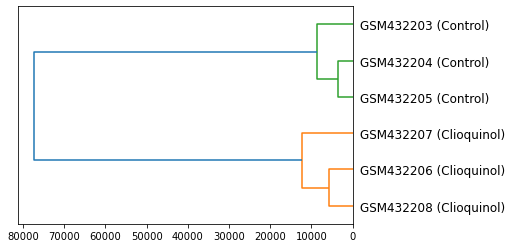

In [5]:
# Compute distance matrix
dist = distance.pdist(gse_filt.transpose(), metric='euclidean')
# Perform hierarchical clustering
phy = hierarchy.linkage(dist, method='ward', metric='euclidean')
# Plot dendrogram
with mpl.rc_context({'figure.figsize': (6, 4)}):
    hierarchy.dendrogram(
        phy, orientation='left', distance_sort='descending',
        labels=[f'{x} ({y})' for x,y in gse_filt.columns.to_flat_index()]
    )

### Clustergram

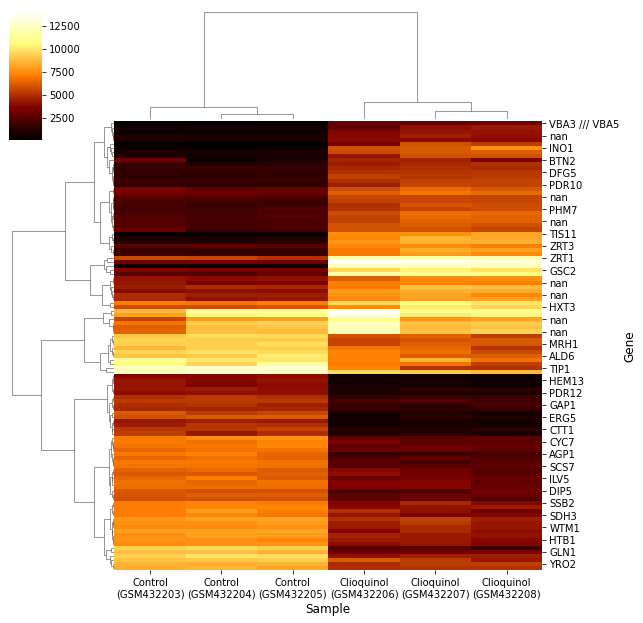

In [6]:
# Create clustergram
fig = sns.clustermap(gse_filt.droplevel(0), method='ward', metric='euclidean',
                     cmap='afmhot', figsize=(9,10), dendrogram_ratio=.2)
## Set axis labels and tick labels
fig.ax_heatmap.set_xlabel('Sample', fontsize=12)
fig.ax_heatmap.set_ylabel('Gene', fontsize=12)
fig.ax_heatmap.set_xticklabels(
    [f'{y}\n({x})' for x,y in gse_filt.columns.to_flat_index()],
    rotation=0, fontsize=10
);

### Differentially Expressed Genes

The top 10 different genes will be selected from genes with high fold changes
(> 1.5, up or down-regulated), ordered by the adjusted p-values.

In [7]:
# Compute the (signed) fold change (Clioquinol / Control)
deg = gse_data.groupby(lambda x: x[1], axis=1).mean()
signed_FC = (deg['Clioquinol'] / deg['Control']).values
deg['signed_FC'] = np.where(signed_FC < 1, -1/signed_FC, signed_FC)

# Compute p-values
deg['pvalue'] = stats.ttest_ind(
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 'Clioquinol'].values,
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 'Control'].values,
    axis=1
).pvalue
# Benjamini-Hochberg FDR Correction
deg['adj_pvalue'] = multitest.fdrcorrection(deg['pvalue'])[1]

# Remove any probes with no Gene symbols mapped
deg = deg.iloc[:, 2:].reset_index().dropna(subset='Gene')
# Select most different genes
deg = deg[ (deg['adj_pvalue'] < .01) & (abs(deg['signed_FC']) > 1.5) ]

# Sort genes by pvalues and  Fold Change
deg = deg \
    .sort_values('signed_FC', key=abs, ascending=False) \
    .sort_values('adj_pvalue') \
    .reset_index(drop=True)

# Report the top 10 most different genes between the Clioquinol and control groups
rich.print(f"[bold]Top 10 Most Different Genes Between Clioquinol and Control Groups[/bold]")
deg.iloc[:10, 1:]

Top 10 Most Different Genes Between Clioquinol and Control Groups

,Gene,signed_FC,pvalue,adj_pvalue
0,GDE1,4.518178,1.851874e-08,0.000141
1,ZPS1,22.450493,5.477797e-08,0.000150
2,NHA1,3.510948,5.420390e-08,0.000150
3,KIN3,-2.904634,1.082083e-07,0.000227
4,STT4,2.612336,1.773988e-07,0.000277
5,SOG2,2.778441,2.520131e-07,0.000344
6,RPC40,-3.450987,2.987672e-07,0.000363
7,SDP1,-2.735229,4.745902e-07,0.000422
8,TUL1,2.056774,4.739991e-07,0.000422
9,DFG5,3.548155,4.738792e-07,0.000422


### Functional Annotations of Differentially Expressed Genes

Functional Annotation analysis was performed using *DAVID Functional Annotation Tool*.  
The results were downloaded to the following files: `'DAVID_BP.txt'`, `'DAVID_KEGG.txt'`.  
The top results returned by DAVID are shown below.

#### Gene Ontology Biological Processes

![Gene Ontology Biological Processes](DAVID_BP.jpg)


#### KEGG Pathways

![KEGG Pathways](DAVID_KEGG.jpg)

### Comparison with Results from *Li, C., Wang, J., & Zhou, B. (2010)*

* The study found 448 downregulated genes and 600 upregulated genes (2-fold change).
* In my analysis, I found 569 significantly downregulated genes and 527 upregulated genes.

In [8]:
print(f"{(deg['signed_FC'] < 0).sum()} Downregulated Genes",
      f"{(deg['signed_FC'] > 0).sum()} Upregulated Genes", sep='\n')

569 Downregulated Genes
527 Upregulated Genes


* The upregulation of 19 transporters (or corresponding regulators) of transition metal ions in
the Clioquinol treated samples was of particular interest in the study.
* In my analysis, 12 of the 19 genes reported were found to be significantly (pvalue < 0.01) upregulated.
  * The fold-change values I computed were within an acceptable margin of error of the values
    reported in the study.
  * The output of the following code block shows the transporter genes found and their Fold changes

In [9]:
study_genes = ['CTR1', 'CTR2', 'FRE1', 'FRE2', 'FRE3', 'FRE5', 'FRE7', 
             'FTR1', 'FET3', 'ENB1', 'ARN1', 'VEL1', 'ZAP1', 'ZPS1', 
             'ZRT1', 'ZRT3', 'PCA1', 'SMF1', 'SMF3']
deg[deg.Gene.isin(study_genes)].reset_index(drop=True)[['Gene', 'signed_FC']]

,Gene,signed_FC
0,ZPS1,22.450493
1,ZRT1,2.215286
2,ZRT3,2.791968
3,FET3,4.370772
4,PCA1,3.215591
5,SMF3,1.963703
6,ENB1,3.073379
7,ZAP1,6.882041
8,SMF1,1.974717
9,FRE3,2.413438


* The differences between the findings reported in the paper and the my results are likely due to the difference in the amount of genes included in the analyses.
  * In the study, only genes with positive signals (significant detection p-values) were used.  
    As such, only 2729 genes (probes) were included in their analysis.
  * However, in my analysis, all 10928 genes (probes) on the microarray were included.  
    
The inclusion of potentially less reliable signals (high detection p-values) is the most likely
cause of the discrepancies between our results.